In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial Setup

### Data

In [3]:
# mpl -> Matplot lib
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)

### Cross Entropy Loss

First we need to calculate softmax (log softmax)

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$

In [9]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(dim=-1, keepdim=True))).log()

In [10]:
sm_pred = log_softmax(pred)

In [11]:
sm_pred.shape

torch.Size([50000, 10])

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [12]:
y_train[:3]

tensor([5, 0, 4])

In [13]:
sm_pred[[0, 1, 2], [0, 1, 0]]

tensor([-2.4165, -2.2180, -2.4276], grad_fn=<IndexBackward>)

In [14]:
def nlloss(input, target):
    return -input[range(target.shape[0]), target].mean()

In [15]:
test_near(nlloss(sm_pred, y_train), F.nll_loss(sm_pred, y_train))

In [16]:
def nlloss2(input, target):
    return -input.gather(1, target.view(-1, 1)).mean()

In [17]:
test_near(nlloss2(sm_pred, y_train), F.nll_loss(sm_pred, y_train))

In [18]:
loss = F.nll_loss(sm_pred, y_train)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [19]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [20]:
test_near(nlloss(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [21]:
pred.shape

torch.Size([50000, 10])

In [22]:
pred.max(-1)[0][:,None].shape

torch.Size([50000, 1])

In [23]:
def logsumexp(x):
    a = x.max(-1)[0]
    return a + (x - a[:, None]).exp().sum(-1).log()

In [24]:
logsumexp(pred).shape

torch.Size([50000])

In [25]:
log_softmax(pred).shape

torch.Size([50000, 10])

In [26]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [27]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [28]:
log_softmax(pred).shape

torch.Size([50000, 10])

In [29]:
test_near(nlloss(log_softmax(pred), y_train), loss)

In [30]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [31]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [32]:
loss_func = F.cross_entropy

In [33]:
#export
def accuracy(out, yb):
    return (torch.argmax(out, dim=-1) == yb).float().mean()

In [34]:
accuracy(pred, y_train)

tensor(0.1057)

In [35]:
bs = 64

In [36]:
xb = x_train[0:bs]

In [37]:
preds = model(xb)
preds[0], preds.shape

(tensor([-0.1185,  0.0302,  0.2481, -0.1457,  0.0385, -0.0834, -0.0884,  0.0141,
          0.0422, -0.0438], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [38]:
yb = y_train[0:bs]
loss_func(xb, yb)

tensor(6.8455)

In [39]:
accuracy(preds, yb)

tensor(0.0781)

In [40]:
lr = 0.5
epochs = 1

In [41]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [42]:
loss_func(model(xb), yb)

tensor(0.1841, grad_fn=<NllLossBackward>)

In [43]:
accuracy(model(xb), yb)

tensor(0.9375)

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [44]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [45]:
model = Model(m, nh, 10)

In [46]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [47]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [48]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = bs * i
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): 
                    p -= p.grad * lr
                model.zero_grad()

In [49]:
fit()

In [50]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1110, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [51]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [52]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [53]:
mdl._modules.values()

dict_values([Linear(in_features=784, out_features=50, bias=True), Linear(in_features=50, out_features=10, bias=True)])

In [54]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [55]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [56]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [57]:
model = Model(layers)

In [58]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

In [59]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [60]:
model = SequentialModel(layers)

In [61]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [62]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2378, grad_fn=<NllLossBackward>), tensor(0.9375))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [63]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [64]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0473, grad_fn=<NllLossBackward>), tensor(1.))

In [65]:
nn.Sequential??

In [66]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [67]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [68]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [69]:
opt = Optimizer(model.parameters())

In [70]:
for epoch in range(epochs):
    for i in range((n -1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [71]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1594, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [72]:
#export
from torch import optim

In [73]:
optim.SGD.step??

In [74]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr = lr)

In [75]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2603, grad_fn=<NllLossBackward>)

In [76]:
for epoch in range(epochs):
    for i in range((n -1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [77]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1505, grad_fn=<NllLossBackward>), tensor(0.9375))

Randomized tests can be very useful.

In [78]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [79]:
#export
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [80]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [81]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28**2)
assert yb.shape == (5, )

In [82]:
model, opt = get_model()

In [83]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [84]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1185, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [85]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i: i + self.bs]

In [86]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [87]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28**2)
assert yb.shape == (bs,)

tensor(3)

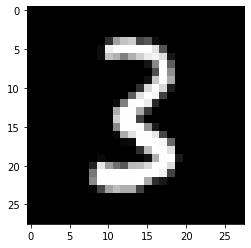

In [88]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [89]:
model, opt = get_model()

In [90]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [91]:
fit()

In [92]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1499, grad_fn=<NllLossBackward>), tensor(0.9531))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [93]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield self.idxs[i: i + self.bs]

In [94]:
x_ds, y_ds = train_ds[:10]
small_ds = Dataset(x_ds, y_ds)

In [95]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [96]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([2, 5, 9]), tensor([6, 7, 1]), tensor([3, 0, 4]), tensor([8])]

In [97]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds,  sampler, collate_fn=collate):
        self.ds = ds
        self.sampler = sampler
        self.collate_fn = collate_fn
        
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [98]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=True)

In [99]:
samp_x = next(iter(train_samp))
xs,ys = zip(*[train_ds[i] for i in samp_x])
torch.stack(xs).shape,torch.stack(ys).shape

(torch.Size([64, 784]), torch.Size([64]))

In [100]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(6)

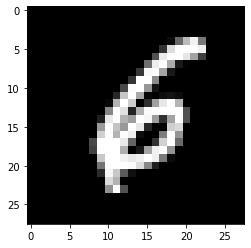

In [101]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [102]:
model, opt = get_model()
fit()
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0592, grad_fn=<NllLossBackward>), tensor(0.9844))

### PyTorch DataLoader

In [103]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [104]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

In [105]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), 
                      collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), 
                      collate_fn=collate)

In [106]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1252, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch's defaults work fine for most things however:

In [107]:
train_dl = DataLoader(train_ds, bs, shuffle=True,  drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [108]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0402, grad_fn=<NllLossBackward>), tensor(1.))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [109]:
len(valid_ds)

10000

In [110]:
x_valid.shape, x_valid.shape[0] // bs, len(valid_dl), bs

(torch.Size([10000, 784]), 156, 157, 64)

In [111]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        for x, y in train_dl:
            loss = loss_func(model(x), y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for x, y in valid_dl:
                pred = model(x)
                tot_loss += loss_func(pred, y)
                tot_acc += accuracy(pred, y)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

`get_dls` returns dataloaders for the training and validation sets:

In [112]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
           DataLoader(valid_ds, batch_size=bs*2, shuffle=False, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [113]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(10, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1461) tensor(0.9576)
1 tensor(0.1240) tensor(0.9615)
2 tensor(0.1344) tensor(0.9596)
3 tensor(0.1225) tensor(0.9658)
4 tensor(0.1004) tensor(0.9712)
5 tensor(0.0984) tensor(0.9733)
6 tensor(0.2823) tensor(0.9325)
7 tensor(0.1054) tensor(0.9721)
8 tensor(0.1571) tensor(0.9524)
9 tensor(0.0978) tensor(0.9732)


In [114]:
assert acc>0.9

## Export

In [115]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
